# Movielens 영화 Session based Recommendation 시스템 제작
### Data Load

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [4]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.

data['Time'] = pd.to_datetime(data['Time'], unit='s') #시간 형식 변경
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## Step 1. 데이터의 전처리

In [5]:
# 유저수, 아이템 수 확인
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

### Session Length

In [6]:
#각 세션이 대략 몇 개의 클릭 데이터를 갖는지
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [7]:
#중앙값, 평균
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [9]:
#최소값, 최댓값
session_length.min(), session_length.max()

(20, 2314)

In [10]:
#분위수
session_length.quantile(0.999)

1343.181000000005

In [13]:
long_session = session_length[session_length == 2314].index[0]
data[data['UserId'] == long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


In [14]:
#하위 99.9% 세션 길이 분포 누적합 시각화
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

Text(0.5, 1.0, 'Cumsum Percentage Until 0.999')

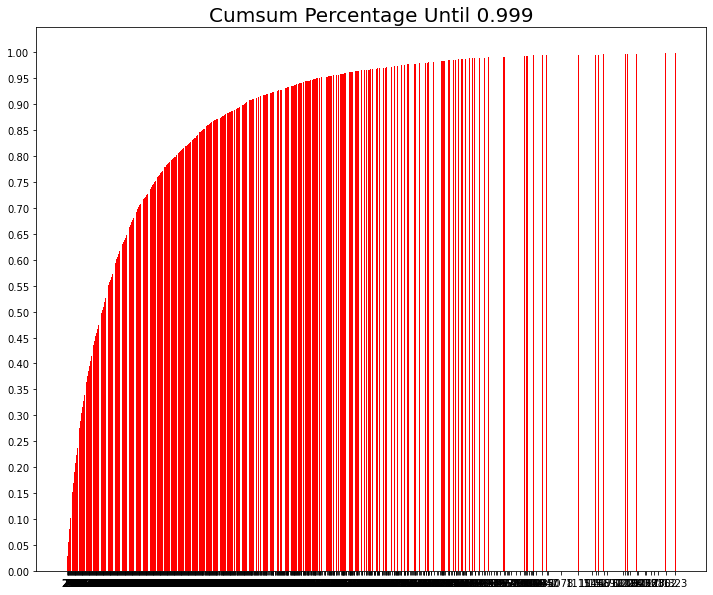

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
plt.bar(x = length_percent_cumsum_999.index,
        height = length_percent_cumsum_999, color = 'red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)

### Session Time 

In [63]:
oldest, latest = data['Time'].min(), data['Time'].max()

print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


### Data Cleansing

In [24]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_watch) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_watch)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_watch):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_watch].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [27]:
data = cleanse_recursive(data, shortest = 2, least_watch = 5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## Step 2. 미니 배치의 구성
### Train / Valid / Test split

In [28]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [31]:
#test,val을 1달 기준 데이터로 나눔
tr, test = split_by_date(data, 180)
tr, val = split_by_date(tr, 180)

In [29]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [32]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 978534
	 Users: 6038
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:19:56

* valid Set Stats Info
	 Events: 12271
	 Users: 399
	 Items: 2606
	 First Time : 2002-03-05 04:21:07
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 8806
	 Users: 339
	 Items: 2317
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



In [33]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

#def indexing(df, id2idx):
    #df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    #return df
    
tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [34]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 3. 모델 구성
### SessionDataset

In [35]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.session_offsets = self.get_session_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        
        return offsets

In [36]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [37]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 978070, 978193, 978534], dtype=int32)

In [38]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6035, 6036, 6037])

### Session Data Loader

In [39]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1   # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [65]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [64]:
iter_ex = iter(tr_data_loader)

In [41]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## Step 4. 모델 학습
### Evaluation Metric

In [42]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [44]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    
    return model

In [45]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [46]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [47]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

## Step 5. 모델 테스트

In [50]:
train_model(model, args)

Evaluation:  15%|█▌        | 7/46 [00:08<00:47,  1.21s/it]


	 - Recall@20 epoch 1: 0.060826
	 - MRR@20    epoch 1: 0.013480



Evaluation:  15%|█▌        | 7/46 [00:07<00:44,  1.13s/it]


	 - Recall@20 epoch 2: 0.095982
	 - MRR@20    epoch 2: 0.024310



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.10s/it]


	 - Recall@20 epoch 3: 0.108259
	 - MRR@20    epoch 3: 0.028039



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.10s/it]


	 - Recall@20 epoch 4: 0.108817
	 - MRR@20    epoch 4: 0.029655



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.09s/it]


	 - Recall@20 epoch 5: 0.115513
	 - MRR@20    epoch 5: 0.032884



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.09s/it]


	 - Recall@20 epoch 6: 0.114955
	 - MRR@20    epoch 6: 0.032239



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.09s/it]


	 - Recall@20 epoch 7: 0.112165
	 - MRR@20    epoch 7: 0.032352



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.09s/it]


	 - Recall@20 epoch 8: 0.112723
	 - MRR@20    epoch 8: 0.033241



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.10s/it]


	 - Recall@20 epoch 9: 0.111607
	 - MRR@20    epoch 9: 0.033597



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.10s/it]

	 - Recall@20 epoch 10: 0.109933
	 - MRR@20    epoch 10: 0.032932



### - 모델1
batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20  
Recall : 0.109933  
MRR : 0.032932  
  
Recall과 MRR이 점점 개선되어가다가 마지막에 성능이 떨어졌다.  
epoch를 늘리면 오버피팅이 일어날 것으로 예상되어 epoch는 수정하지 않고 batch_size를 낮춰 모델 2를 테스트해보겠다.  

## STEP 6. 모델 개선으로 Recall, MRR 등 변화추이 관찰

In [54]:
args2 = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)  #batchsize=32로 변경

In [55]:
model2 = create_model(args2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(32, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      520200    
_________________________________________________________________
dropout_2 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (32, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [56]:
train_model(model2, args2)

Evaluation:  83%|████████▎ | 307/371 [00:50<00:10,  6.04it/s]


	 - Recall@20 epoch 1: 0.123270
	 - MRR@20    epoch 1: 0.032402



Evaluation:  83%|████████▎ | 307/371 [00:50<00:10,  6.08it/s]


	 - Recall@20 epoch 2: 0.135993
	 - MRR@20    epoch 2: 0.039026



Evaluation:  83%|████████▎ | 307/371 [00:50<00:10,  6.02it/s]


	 - Recall@20 epoch 3: 0.140371
	 - MRR@20    epoch 3: 0.041249



Evaluation:  83%|████████▎ | 307/371 [00:50<00:10,  6.08it/s]


	 - Recall@20 epoch 4: 0.140472
	 - MRR@20    epoch 4: 0.042419



Evaluation:  83%|████████▎ | 307/371 [00:50<00:10,  6.09it/s]


	 - Recall@20 epoch 5: 0.140879
	 - MRR@20    epoch 5: 0.041706



Evaluation:  83%|████████▎ | 307/371 [00:50<00:10,  6.07it/s]


	 - Recall@20 epoch 6: 0.141897
	 - MRR@20    epoch 6: 0.042005



Evaluation:  83%|████████▎ | 307/371 [00:50<00:10,  6.10it/s]


	 - Recall@20 epoch 7: 0.142712
	 - MRR@20    epoch 7: 0.042094



Evaluation:  83%|████████▎ | 307/371 [00:50<00:10,  6.10it/s]


	 - Recall@20 epoch 8: 0.141185
	 - MRR@20    epoch 8: 0.042121



Evaluation:  83%|████████▎ | 307/371 [00:50<00:10,  6.03it/s]


	 - Recall@20 epoch 9: 0.143221
	 - MRR@20    epoch 9: 0.042623



Evaluation:  83%|████████▎ | 307/371 [00:50<00:10,  6.08it/s]

	 - Recall@20 epoch 10: 0.141388
	 - MRR@20    epoch 10: 0.042561



### - 모델2
batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20  
Recall : 0.141388  
MRR : 0.042561  

batch_size를 낮추니 Recall과 MRR이 훨씬 개선되었다.  
batch_size를 낮게 하니 모델 학습 시간도 훨씬 오래 걸렸다.  
이전과 같이 마지막에 성능이 향상된 것으로 보아 epoch 9에서 가장 개선된 모델이 출력된다고 보인다.  
모델 1과의 비교를 위해 batch_size를 256으로 두고, hidden state를 향상시켜 모델 학습을 실시해보겠다.  

In [57]:
args3 = Args(tr, val, test, batch_size=256, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)  #hsz=100으로 수정 

In [58]:
model3 = create_model(args3)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 100), (256, 100)]  1055400   
_________________________________________________________________
dropout_3 (Dropout)          (256, 100)                0         
_________________________________________________________________
dense_3 (Dense)              (256, 3416)               345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


In [59]:
train_model(model3, args3)

Evaluation:  15%|█▌        | 7/46 [00:08<00:45,  1.16s/it]


	 - Recall@20 epoch 1: 0.079241
	 - MRR@20    epoch 1: 0.020340



Evaluation:  15%|█▌        | 7/46 [00:07<00:43,  1.11s/it]


	 - Recall@20 epoch 2: 0.103795
	 - MRR@20    epoch 2: 0.029525



Evaluation:  15%|█▌        | 7/46 [00:07<00:43,  1.11s/it]


	 - Recall@20 epoch 3: 0.102679
	 - MRR@20    epoch 3: 0.030774



Evaluation:  15%|█▌        | 7/46 [00:07<00:43,  1.11s/it]


	 - Recall@20 epoch 4: 0.107701
	 - MRR@20    epoch 4: 0.032387



Evaluation:  15%|█▌        | 7/46 [00:07<00:43,  1.12s/it]


	 - Recall@20 epoch 5: 0.111607
	 - MRR@20    epoch 5: 0.033739



Evaluation:  15%|█▌        | 7/46 [00:07<00:43,  1.13s/it]


	 - Recall@20 epoch 6: 0.109933
	 - MRR@20    epoch 6: 0.033712



Evaluation:  15%|█▌        | 7/46 [00:07<00:43,  1.11s/it]


	 - Recall@20 epoch 7: 0.107701
	 - MRR@20    epoch 7: 0.032993



Evaluation:  15%|█▌        | 7/46 [00:07<00:43,  1.11s/it]


	 - Recall@20 epoch 8: 0.105469
	 - MRR@20    epoch 8: 0.033689



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.10s/it]


	 - Recall@20 epoch 9: 0.104911
	 - MRR@20    epoch 9: 0.034031



Evaluation:  15%|█▌        | 7/46 [00:07<00:43,  1.11s/it]

	 - Recall@20 epoch 10: 0.107143
	 - MRR@20    epoch 10: 0.034162



### - 모델3
batch_size=256, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20  
Recall : 0.107143  
MRR : 0.034162  
  
모델 1의 결과가 Recall : 0.109933  MRR : 0.032932  였던것과 비교하면 거의 변화가 없다.  
그래도 약간 개선되어 hidden state를 높이는 것이 모델 개선에 효과가 있다는 것을 알 수 있었다.  
hidden state를 향상시킨 상태로 k를 높여 모델 학습을 해보겠다.  

In [60]:
args4 = Args(tr, val, test, batch_size=256, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=50)  #k=50으로 수정

In [61]:
model4 = create_model(args4)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 100), (256, 100)]  1055400   
_________________________________________________________________
dropout_4 (Dropout)          (256, 100)                0         
_________________________________________________________________
dense_4 (Dense)              (256, 3416)               345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


In [62]:
train_model(model4, args4)

Evaluation:  15%|█▌        | 7/46 [00:17<01:36,  2.49s/it]


	 - Recall@50 epoch 1: 0.145647
	 - MRR@50    epoch 1: 0.023032



Evaluation:  15%|█▌        | 7/46 [00:16<01:34,  2.42s/it]


	 - Recall@50 epoch 2: 0.179688
	 - MRR@50    epoch 2: 0.029953



Evaluation:  15%|█▌        | 7/46 [00:16<01:32,  2.38s/it]


	 - Recall@50 epoch 3: 0.186384
	 - MRR@50    epoch 3: 0.032926



Evaluation:  15%|█▌        | 7/46 [00:16<01:33,  2.40s/it]


	 - Recall@50 epoch 4: 0.192522
	 - MRR@50    epoch 4: 0.033862



Evaluation:  15%|█▌        | 7/46 [00:16<01:31,  2.36s/it]


	 - Recall@50 epoch 5: 0.189174
	 - MRR@50    epoch 5: 0.035837



Evaluation:  15%|█▌        | 7/46 [00:16<01:33,  2.39s/it]


	 - Recall@50 epoch 6: 0.189732
	 - MRR@50    epoch 6: 0.037457



Evaluation:  15%|█▌        | 7/46 [00:16<01:32,  2.38s/it]


	 - Recall@50 epoch 7: 0.188616
	 - MRR@50    epoch 7: 0.035869



Evaluation:  15%|█▌        | 7/46 [00:16<01:33,  2.39s/it]


	 - Recall@50 epoch 8: 0.186942
	 - MRR@50    epoch 8: 0.036411



Evaluation:  15%|█▌        | 7/46 [00:16<01:32,  2.38s/it]


	 - Recall@50 epoch 9: 0.189732
	 - MRR@50    epoch 9: 0.036561



Evaluation:  15%|█▌        | 7/46 [00:16<01:31,  2.35s/it]

	 - Recall@50 epoch 10: 0.193080
	 - MRR@50    epoch 10: 0.037483



### - 모델4
batch_size=256, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=50  
Recall : 0.193080  
MRR : 0.037483  
  
k가 20이었던 모델 3과 비교해보면, Recall : 0.107143 MRR : 0.034162 이었기 때문에 약간 개선되었다고 볼 수 있다.  
  
결론적으로 batch_size를 낮게했을 때 가장 좋은 결과가 나왔고 hsz와 k를 늘리는 것도 모델 개선에 약소하게 도움이 된다는 사실을 알 수 있다.  

### Inference

In [67]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")
    
test_model(model2, args2, test) #가장 성능이 좋았던 모델2

Evaluation:  73%|███████▎  | 194/264 [00:31<00:11,  6.08it/s]

	 - Recall@20: 0.154961
	 - MRR@20: 0.047866



4개의 모델 중 그나마 가장 성능이 좋았던 모델 2를 평가해보았다.  
결론적으로 보았을 땐 성능이 매우 좋지 않은 모델이 나왔다.

## EXPLORATION 16 회고
  
4가지의 모델 학습을 했고, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20였을 때 가장 성능이 개선된 모델을 보였다.  
batch_size를 낮게 할 수록 모델의 성능이 개선되는 것 같았는데 그만큼 모델 학습이 정말 오래걸렸다.  
기본적으로 모델의 성능이 좋지 않게 나와서 아쉽다. 원래 이정도 개선이 되는건지 내가 개선을 잘 못시킨건지 궁금하다.  
모델학습을 하는데 에러가 많이 나고 어려웠던 부분이 많아서 익스의 내용을 전반적으로 모두 이해하며 지나가지 못해 아쉽다.  
특히 프로젝트를 진행함에도 불구하고 SBR에 대한 이해도가 낮은게 가장 아쉬운 점이다.  
프로젝트를 하며 가장 힘들었던 점은 1) index is out of bounds for axis 0 with size 에러 2) 데이터셋 전처리 과정에서 Time의 유형을 변경해주는 것이 가장 어려웠다.  
우선은 아무런 오류 없이 제출한다는 점에서 만족한다. 배치사이즈를 낮춰도 엄청나게 개선되지는 않기 때문에, 지금 모델에서 모델 성능을 더 개선시키기 위해서 어떤 방법을 더 쓸 수 있는지 궁금하다.  